In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from keras import Input
from keras.preprocessing.image import image_dataset_from_directory, array_to_img, img_to_array, load_img
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.applications.mobilenet_v2 import preprocess_input
from keras.models import Model, load_model
import matplotlib.pyplot as plt
import os
import numpy as np

In [ ]:
plt.rcParams['font.family'] = 'malgun gothic'

## GPU 메모리 제한

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

## 하이퍼파라미터 설정

In [ ]:
image_size = (224, 224)
input_shape = (224, 224, 3)
batch_size = 64
training_epochs = 10

## 모델 체크포인트 설정

In [ ]:
checkpoint_dir = './checkpoints/version1/'
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

checkpoint_path = checkpoint_dir + 'cp-{epoch:04d}-{accuracy:.3f}.ckpt'
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='accuracy',
    mode='max',
    save_weights_only=True,
    save_best_only=True,
    save_freq=5
)

## 데이터셋 로드

In [ ]:
training_set = image_dataset_from_directory(directory='./data/train/',
                                            image_size=image_size,
                                            batch_size=batch_size,
                                            label_mode='categorical',
                                            shuffle=True)

validation_set = image_dataset_from_directory(directory='./data/valid/',
                                              image_size=image_size,
                                              batch_size=batch_size,
                                              label_mode='categorical',
                                              shuffle=False)

Found 609923 files belonging to 15 classes.
Found 76377 files belonging to 15 classes.


## 모델 설계

In [ ]:
base_model = MobileNetV2(input_shape=input_shape,
                         include_top=False,
                         weights='imagenet')

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

사전 학습된 모델의 가중치 업데이트를 하지 않음

In [ ]:
base_model.trainable = False

이미지의 정규화

In [ ]:
preproecss_input = tf.keras.applications.mobilenet_v2.preprocess_input

이미지 정규화 반영 <br>
Dropout 레이어 추가 (Overfitting 방지) <br>
Flatten 레이어 추가 (1차원으로 변환) <br>
Dense 레이어 추가 (softmax) <br>

In [ ]:
inputs = tf.keras.Input(shape=input_shape)
x = preproecss_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(15, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 7, 7, 1280)        0         
                                                             

모델 컴파일

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

학습

In [ ]:
history = model.fit(training_set,
                    epochs=training_epochs,
                    validation_data=validation_set,
                    verbose=1,
                    callbacks=[cp_callback])

Epoch 1/10
9531/9531 [==============================] - 1714s 180ms/step - loss: 0.4515 - accuracy: 0.8573 - val_loss: 0.5084 - val_accuracy: 0.8442
Epoch 2/10
9531/9531 [==============================] - 1752s 184ms/step - loss: 0.4096 - accuracy: 0.8701 - val_loss: 0.5292 - val_accuracy: 0.8440
Epoch 3/10
9531/9531 [==============================] - 1963s 206ms/step - loss: 0.3835 - accuracy: 0.8778 - val_loss: 0.5150 - val_accuracy: 0.8484
Epoch 4/10
9531/9531 [==============================] - 1541s 162ms/step - loss: 0.3636 - accuracy: 0.8839 - val_loss: 0.5431 - val_accuracy: 0.8465
Epoch 5/10
9531/9531 [==============================] - 1542s 162ms/step - loss: 0.3503 - accuracy: 0.8882 - val_loss: 0.5656 - val_accuracy: 0.8428
Epoch 6/10
9531/9531 [==============================] - 1575s 165ms/step - loss: 0.3405 - accuracy: 0.8910 - val_loss: 0.5757 - val_accuracy: 0.8463
Epoch 7/10
9531/9531 [==============================] - 1637s 172ms/step - loss: 0.3324 - accuracy: 0.8937

## 학습 결과

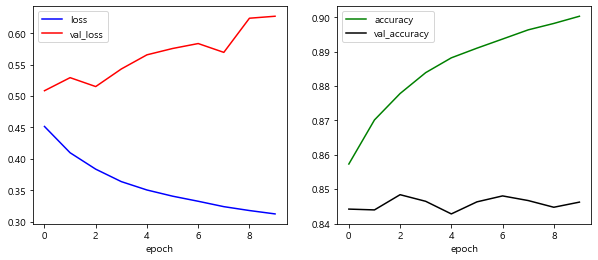

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r-', label='val_loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k-', label='val_accuracy')
plt.xlabel('epoch')
plt.legend()

plt.show()

## 모델의 모듈화

In [ ]:
class ImageModel:
    def __init__(self):
        self.base_model = MobileNetV2(input_shape=input_shape,
                                      include_top=False,
                                      weights='imagenet')

    def create_model(self):
        inputs = Input(shape=input_shape)
        x = preprocess_input(inputs)
        x = self.base_model(x, training=False)
        x = Dropout(rate=0.2)(x)
        x = Flatten()(x)
        x = Dense(units=128, activation='relu')(x)
        outputs = Dense(units=15, activation='softmax')(x)
        model = Model(inputs, outputs)
        model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model

In [ ]:
class_names = list(training_set.class_names)
print(class_names)

['가구류', '고철류', '나무', '도기류', '비닐', '스티로폼', '유리병', '의류', '자전거', '전자제품', '종이류', '캔류', '페트병', '플라스틱류', '형광등']


In [ ]:
class ImageModelClassifier(ImageModel):
    def __init__(self):
        super().__init__()
        self.model = super().create_model()
        self.labels = class_names

    def create_model_by_load_model(self, path):
        self.model = load_model(path)

    def update_weight_by_load_weights(self, path):
        latest = tf.train.latest_checkpoint(path)
        self.model.load_weights(latest)

    def train(self, training_set, training_epochs, valid_set, checkpoint_dir, callbacks):
        if not os.path.exists(checkpoint_dir):
            os.mkdir(checkpoint_dir)

        self.model.fit(training_set,
                       epochs=training_epochs,
                       validation_data=valid_set,
                       verbose=1,
                       callbacks=[callbacks])

    def save_model(self):
        self.model.save(checkpoint_dir + 'trash_model.h5')

    def predict(self, path):
        image = load_img(path, target_size=image_size)
        image_nparray = img_to_array(image)
        input_batch = np.array([image_nparray])
        prediction = self.model.predict(input_batch)
        prediction = np.argmax(prediction)
        prediction_name = self.labels[prediction]
        print(prediction_name)

    def evaluate(self, valid_set):
        return self.model.evaluate(valid_set, verbose=1)

## pre-trained model의 성능

In [ ]:
model_module = ImageModelClassifier()

In [ ]:
model_module.model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 1280)        0         
                                                           

In [ ]:
model_module.update_weight_by_load_weights('./checkpoints/version1/')

In [ ]:
model_module.evaluate(validation_set)

1194/1194 [==============================] - 146s 121ms/step - loss: 0.5457 - accuracy: 0.8458


[0.545663058757782, 0.8458174467086792]

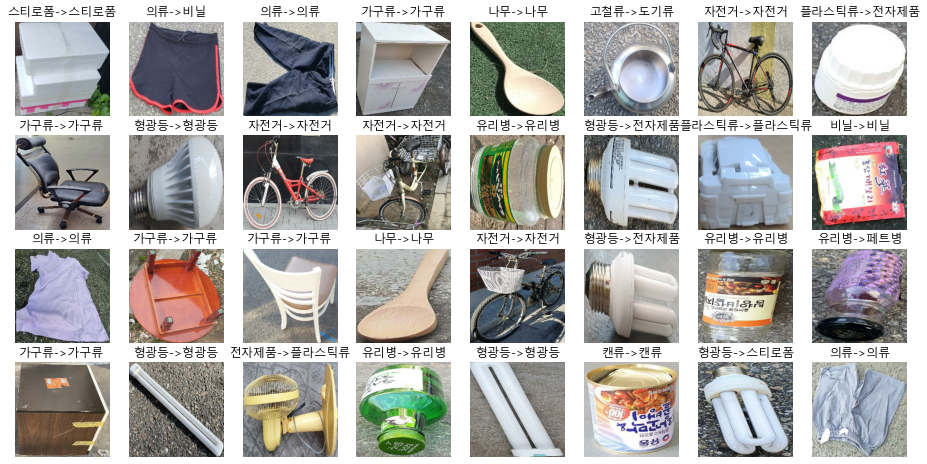

In [ ]:
plt.figure(figsize=(16, 8))

for images, labels in training_set.take(1):
    for i in range(32):
        predictions = model_module.model.predict(images)
        
        ax = plt.subplot(4, 8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        class_index = np.argmax(labels[i].numpy())
        
        real_label = class_names[class_index]
        predicted_label = class_names[np.argmax(predictions[i])]
        
        plt.title(real_label + '->' + predicted_label)
        plt.axis('off')